In [1]:
import QUANTAXIS as QA
try:
    assert QA.__version__>='1.1.0'
except AssertionError:
    print('pip install QUANTAXIS >= 1.1.0 请升级QUANTAXIS后再运行此示例')

In [2]:
print('首先确定你已经完成了对于QUANTAXIS的基础认知,以及在本地存储完毕了QUANTAXIS的数据库')

首先确定你已经完成了对于QUANTAXIS的基础认知,以及在本地存储完毕了QUANTAXIS的数据库


# QUANTAXIS 回测的一些基础知识

##  QA回测的核心是两个类

```
QA_BacktestBroker
QA_Account
```

##  回测数据的引入/迭代

```
QA.QA_fetch_stock_day_adv
QA.QA_fetch_stock_min_adv
```

##  指标的计算

```
DataStruct.add_func
```

##  对于账户的灵活运用

```
QA_Account
QA_Risk
QA_Portfolio
QA_PortfolioView
QA_User
```

## STEP1 初始化账户,初始化回测broker

In [3]:
Account=QA.QA_Account()
Broker=QA.QA_BacktestBroker()

In [4]:
import warnings

In [5]:
# # 打印账户的信息
# try:
#     from pprint import  pprint as print
# except:
#     pass
# print(Account.message)

## 首先讲解Account类:

QA_Account在初始化的时候,可以自己指定很多信息:

```

    QA_Account(
        strategy_name=None, user_cookie=None, portfolio_cookie=None, account_cookie=None,
        market_type=MARKET_TYPE.STOCK_CN, frequence=FREQUENCE.DAY, broker=BROKER_TYPE.BACKETEST,
        init_hold={}, init_cash=1000000, commission_coeff=0.00025, tax_coeff=0.0015,
        margin_level=False, allow_t0=False, allow_sellopen=False,
        running_environment=RUNNING_ENVIRONMENT.BACKETEST)

        :param [str] strategy_name:  策略名称
        :param [str] user_cookie:   用户cookie
        :param [str] portfolio_cookie: 组合cookie
        :param [str] account_cookie:   账户cookie

        :param [dict] init_hold         初始化时的股票资产
        :param [float] init_cash:         初始化资金
        :param [float] commission_coeff:  交易佣金 :默认 万2.5   float 类型
        :param [float] tax_coeff:         印花税   :默认 千1.5   float 类型

        :param [Bool] margin_level:      保证金比例 默认False
        :param [Bool] allow_t0:          是否允许t+0交易  默认False
        :param [Bool] allow_sellopen:    是否允许卖空开仓  默认False

        :param [QA.PARAM] market_type:   市场类别 默认QA.MARKET_TYPE.STOCK_CN A股股票
        :param [QA.PARAM] frequence:     账户级别 默认日线QA.FREQUENCE.DAY
        :param [QA.PARAM] broker:        BROEKR类 默认回测 QA.BROKER_TYPE.BACKTEST
        :param [QA.PARAM] running_environment 当前运行环境 默认Backtest

        # 2018/06/11 init_assets 从float变为dict,并且不作为输入,作为只读属性
        #  :param [float] init_assets:       初始资产  默认 1000000 元 （100万）
        init_assets:{
            cash: xxx,
            stock: {'000001':2000},
            init_date: '2018-02-05',
            init_datetime: '2018-02-05 15:00:00'
        }
        # 2018/06/11 取消在初始化的时候的cash和history输入
        # :param [list] cash:              可用现金  默认 是 初始资产  list 类型
        # :param [list] history:           交易历史
```

In [6]:
# 重设账户初始资金

Account.reset_assets(200000)
Account.account_cookie='JCSC_EXAMPLE'

In [7]:
Account.init_assets

{'cash': 200000, 'hold': {}}

Account 有很多方法,暂时不详细展开,我们先直接进入下一步

# SETP2:引入回测的市场数据

引入方法非常简单,直接使用QA_fetch_stock_day_adv系列即可

- code 可以是多种多样的选取方式

```python
1. QA.QA_fetch_stock_list_adv().code.tolist() # 获取全市场的股票代码
2. QA.QA_fetch_stock_block_adv().get_block('云计算').code  # 按版块选取
3. code= ['000001','000002'] # 自己指定
```
- 数据获取后,to_qfq() 即可获得前复权数据

```python
data=DataSturct.to_qfq()
```

In [8]:
# QA.QA_fetch_stock_list_adv().code.tolist()
# QA.QA_fetch_stock_block_adv().get_block('云计算').code
#codelist=QA.QA_fetch_stock_block_adv().get_block('云计算').code
codelist=['000001']

In [9]:
data=QA.QA_fetch_stock_day_adv(codelist,'2017-09-01','2018-05-20')

In [10]:
data

< QA_DataStruct_Stock_day with 1 securities >

In [11]:
data=data.to_qfq()

In [12]:
# data.data

## STEP3:计算一些指标

指标的计算可以在回测前,也可以在回测中进行

回测前的计算则是批量计算,效率较高

回测中的计算,效率略低,但代码量较小,易于理解

PS: 指标的相关介绍参见 [QUANTAXIS的指标系统](https://github.com/QUANTAXIS/QUANTAXIS/blob/master/Documents/indicators.md)

In [13]:
import numpy as np
import pandas as pd
def MACD_JCSC(dataframe,SHORT=12,LONG=26,M=9):
    """
    1.DIF向上突破DEA，买入信号参考。
    
    2.DIF向下跌破DEA，卖出信号参考。
    """
    CLOSE=dataframe.close
    DIFF =QA.EMA(CLOSE,SHORT) - QA.EMA(CLOSE,LONG)
    DEA = QA.EMA(DIFF,M)
    MACD =2*(DIFF-DEA)

    CROSS_JC=QA.CROSS(DIFF,DEA)
    CROSS_SC=QA.CROSS(DEA,DIFF)
    ZERO=0
    return pd.DataFrame({'DIFF':DIFF,'DEA':DEA,'MACD':MACD,'CROSS_JC':CROSS_JC,'CROSS_SC':CROSS_SC,'ZERO':ZERO})

In [14]:
ind=data.add_func(MACD_JCSC)

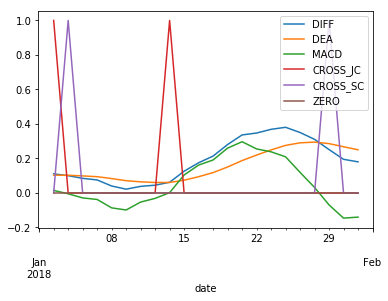

In [15]:
ind.xs(codelist[0],level=1)['2018-01'].plot()

In [16]:
ind.xs(codelist[0],level=1)['2018-01']

,DIFF,DEA,MACD,CROSS_JC,CROSS_SC,ZERO
date,,,,,,
2018-01-02,0.110686,0.103225,0.014921,1,0,0
2018-01-03,0.100387,0.102657,-0.004541,0,1,0
2018-01-04,0.084801,0.099086,-0.028570,0,0,0
2018-01-05,0.075607,0.094390,-0.037566,0,0,0
2018-01-08,0.040453,0.083603,-0.086299,0,0,0
2018-01-09,0.022012,0.071285,-0.098545,0,0,0
2018-01-10,0.038391,0.064706,-0.052629,0,0,0
2018-01-11,0.045208,0.060806,-0.031197,0,0,0
2018-01-12,0.061988,0.061043,0.001890,1,0,0


In [17]:
ind.loc['2018-01',slice(None)]

,,DIFF,DEA,MACD,CROSS_JC,CROSS_SC,ZERO
date,code,,,,,,
2018-01-02,000001,0.110686,0.103225,0.014921,1,0,0
2018-01-03,000001,0.100387,0.102657,-0.004541,0,1,0
2018-01-04,000001,0.084801,0.099086,-0.028570,0,0,0
2018-01-05,000001,0.075607,0.094390,-0.037566,0,0,0
2018-01-08,000001,0.040453,0.083603,-0.086299,0,0,0
2018-01-09,000001,0.022012,0.071285,-0.098545,0,0,0
2018-01-10,000001,0.038391,0.064706,-0.052629,0,0,0
2018-01-11,000001,0.045208,0.060806,-0.031197,0,0,0
2018-01-12,000001,0.061988,0.061043,0.001890,1,0,0


# SETP4:选取回测的开始和结束日期,构建回测

In [18]:
data_forbacktest=data.select_time('2018-01-01','2018-05-01')


for items in data_forbacktest.panel_gen:
    for item in items.security_gen:
        daily_ind=ind.loc[item.index]
        if daily_ind.CROSS_JC.iloc[0]>0:
            order=Account.send_order(
                code=item.code[0], 
                time=item.date[0], 
                amount=1000, 
                towards=QA.ORDER_DIRECTION.BUY, 
                price=0, 
                order_model=QA.ORDER_MODEL.CLOSE, 
                amount_model=QA.AMOUNT_MODEL.BY_AMOUNT
                )
            #print(item.to_json()[0])
            Broker.receive_order(QA.QA_Event(order=order,market_data=item))
            
            
            trade_mes=Broker.query_orders(Account.account_cookie,'filled')
            res=trade_mes.loc[order.account_cookie,order.realorder_id]
            order.trade(res.trade_id,res.trade_price,res.trade_amount,res.trade_time)
        elif daily_ind.CROSS_SC.iloc[0]>0:
            if Account.sell_available.get(item.code[0], 0)>0:
                order=Account.send_order(
                    code=item.code[0], 
                    time=item.date[0], 
                    amount=Account.sell_available.get(item.code[0], 0), 
                    towards=QA.ORDER_DIRECTION.SELL, 
                    price=0, 
                    order_model=QA.ORDER_MODEL.MARKET, 
                    amount_model=QA.AMOUNT_MODEL.BY_AMOUNT
                    )
                Broker.receive_order(QA.QA_Event(order=order,market_data=item))


                trade_mes=Broker.query_orders(Account.account_cookie,'filled')
                res=trade_mes.loc[order.account_cookie,order.realorder_id]
                order.trade(res.trade_id,res.trade_price,res.trade_amount,res.trade_time)
    Account.settle()
            
        #break

receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal


## STEP5: 分析账户

In [19]:
Account.history

[['2018-01-02 00:00:00',
  '000001',
  13.7,
  1000,
  186295.0,
  'Order_FemEzpZ0',
  'Order_FemEzpZ0',
  'Trade_TQzDbd0g',
  'JCSC_EXAMPLE',
  5,
  0,
  None],
 ['2018-01-03 00:00:00',
  '000001',
  13.53,
  -1000,
  199806.47,
  'Order_mnKfLY0M',
  'Order_mnKfLY0M',
  'Trade_ldhSrMYa',
  'JCSC_EXAMPLE',
  5,
  13.530000000000001,
  None],
 ['2018-01-12 00:00:00',
  '000001',
  13.55,
  1000,
  186251.47,
  'Order_nWrOyhV4',
  'Order_nWrOyhV4',
  'Trade_AkSzOM7i',
  'JCSC_EXAMPLE',
  5,
  0,
  None],
 ['2018-01-29 00:00:00',
  '000001',
  13.93,
  -1000,
  200162.54,
  'Order_ygQNXbEJ',
  'Order_ygQNXbEJ',
  'Trade_HW4C7STK',
  'JCSC_EXAMPLE',
  5,
  13.93,
  None],
 ['2018-03-08 00:00:00',
  '000001',
  12.11,
  1000,
  188047.54,
  'Order_osmdlg2w',
  'Order_osmdlg2w',
  'Trade_UpRMLDi9',
  'JCSC_EXAMPLE',
  5,
  0,
  None],
 ['2018-03-26 00:00:00',
  '000001',
  11.03,
  -1000,
  199061.51,
  'Order_07LT6nZE',
  'Order_07LT6nZE',
  'Trade_kQDMnIJH',
  'JCSC_EXAMPLE',
  5,
  11.03,

In [20]:
Account.history_table

,datetime,code,price,amount,cash,order_id,realorder_id,trade_id,account_cookie,commission,tax,message
0,2018-01-02 00:00:00,000001,13.70,1000,186295.00,Order_FemEzpZ0,Order_FemEzpZ0,Trade_TQzDbd0g,JCSC_EXAMPLE,5,0.00,None
1,2018-01-03 00:00:00,000001,13.53,-1000,199806.47,Order_mnKfLY0M,Order_mnKfLY0M,Trade_ldhSrMYa,JCSC_EXAMPLE,5,13.53,None
2,2018-01-12 00:00:00,000001,13.55,1000,186251.47,Order_nWrOyhV4,Order_nWrOyhV4,Trade_AkSzOM7i,JCSC_EXAMPLE,5,0.00,None
3,2018-01-29 00:00:00,000001,13.93,-1000,200162.54,Order_ygQNXbEJ,Order_ygQNXbEJ,Trade_HW4C7STK,JCSC_EXAMPLE,5,13.93,None
4,2018-03-08 00:00:00,000001,12.11,1000,188047.54,Order_osmdlg2w,Order_osmdlg2w,Trade_UpRMLDi9,JCSC_EXAMPLE,5,0.00,None
5,2018-03-26 00:00:00,000001,11.03,-1000,199061.51,Order_07LT6nZE,Order_07LT6nZE,Trade_kQDMnIJH,JCSC_EXAMPLE,5,11.03,None
6,2018-04-10 00:00:00,000001,11.42,1000,187636.51,Order_r9Mdl61s,Order_r9Mdl61s,Trade_zA7EdDj0,JCSC_EXAMPLE,5,0.00,None


In [21]:
#pd.concat([Account.daily_hold.reset_index().set_index('date'),pd.Series(data=None,index=pd.to_datetime(Account.trade_range).set_names('date'),name='predrop')],axis=1).ffill().drop(['predrop'],axis=1).reset_index()

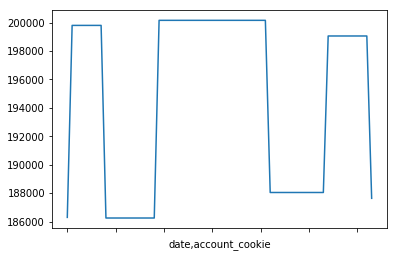

In [22]:
Account.daily_cash.cash.plot()

In [23]:
Account.daily_hold

,,000001
date,account_cookie,
2018-01-02,JCSC_EXAMPLE,1000.0
2018-01-03,JCSC_EXAMPLE,0.0
2018-01-04,JCSC_EXAMPLE,0.0
2018-01-05,JCSC_EXAMPLE,0.0
2018-01-08,JCSC_EXAMPLE,0.0
2018-01-09,JCSC_EXAMPLE,0.0
2018-01-10,JCSC_EXAMPLE,0.0
2018-01-11,JCSC_EXAMPLE,0.0
2018-01-12,JCSC_EXAMPLE,1000.0


In [24]:
Risk=QA.QA_Risk(Account)

In [25]:
Risk.message

{'account_cookie': 'JCSC_EXAMPLE',
 'portfolio_cookie': None,
 'user_cookie': None,
 'annualize_return': -0.02,
 'profit': -0.0,
 'max_dropback': 0.01,
 'time_gap': 64,
 'volatility': 0.01,
 'benchmark_code': '000300',
 'bm_annualizereturn': -0.15,
 'bm_profit': -0.03,
 'beta': 1.0,
 'alpha': 0.13,
 'sharpe': -7.0,
 'init_cash': '200000.00',
 'last_assets': '199056.51',
 'total_tax': -38.49,
 'total_commission': -35.0,
 'profit_money': -943.49,
 'assets': [199995.0,
  199806.47,
  199806.47,
  199806.47,
  199806.47,
  199806.47,
  199806.47,
  199806.47,
  199801.47,
  200451.47,
  200451.47,
  200481.47,
  200971.47,
  201051.47,
  200691.47,
  200901.47,
  200891.47,
  200451.47,
  200301.47,
  200162.54,
  200162.54,
  200162.54,
  200162.54,
  200162.54,
  200162.54,
  200162.54,
  200162.54,
  200162.54,
  200162.54,
  200162.54,
  200162.54,
  200162.54,
  200162.54,
  200162.54,
  200162.54,
  200162.54,
  200162.54,
  200162.54,
  200162.54,
  200162.54,
  200162.54,
  200162.

In [26]:
Risk.market_value.diff().iloc[-1]

code
000001    11420.0
Name: (2018-04-10 00:00:00, JCSC_EXAMPLE), dtype: float64

In [27]:
Risk.account.cash_table

,,cash,datetime,date,account_cookie
datetime,account_cookie,,,,
2018-01-02 00:00:00,JCSC_EXAMPLE,186295,2018-01-02 00:00:00,2018-01-02,JCSC_EXAMPLE
2018-01-03 00:00:00,JCSC_EXAMPLE,199806,2018-01-03 00:00:00,2018-01-03,JCSC_EXAMPLE
2018-01-12 00:00:00,JCSC_EXAMPLE,186251,2018-01-12 00:00:00,2018-01-12,JCSC_EXAMPLE
2018-01-29 00:00:00,JCSC_EXAMPLE,200163,2018-01-29 00:00:00,2018-01-29,JCSC_EXAMPLE
2018-03-08 00:00:00,JCSC_EXAMPLE,188048,2018-03-08 00:00:00,2018-03-08,JCSC_EXAMPLE
2018-03-26 00:00:00,JCSC_EXAMPLE,199062,2018-03-26 00:00:00,2018-03-26,JCSC_EXAMPLE
2018-04-10 00:00:00,JCSC_EXAMPLE,187637,2018-04-10 00:00:00,2018-04-10,JCSC_EXAMPLE


In [28]:
z=Account.cash_table.drop_duplicates(subset='date', keep='last').set_index(['date', 'account_cookie'], drop=False)

In [29]:
res=Account.cash_table.drop_duplicates(subset='date', keep='last')

zx=pd.concat([res.set_index('date'),pd.Series(data=None,index=pd.to_datetime(Account.trade_range),name='predrop')],axis=1).ffill().drop(['predrop'],axis=1)


In [30]:
zxx=pd.to_datetime(Account.trade_range)

In [31]:
zxx.set_names('date')

DatetimeIndex(['2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',
               '2018-01-08', '2018-01-09', '2018-01-10', '2018-01-11',
               '2018-01-12', '2018-01-15', '2018-01-16', '2018-01-17',
               '2018-01-18', '2018-01-19', '2018-01-22', '2018-01-23',
               '2018-01-24', '2018-01-25', '2018-01-26', '2018-01-29',
               '2018-01-30', '2018-01-31', '2018-02-01', '2018-02-02',
               '2018-02-05', '2018-02-06', '2018-02-07', '2018-02-08',
               '2018-02-09', '2018-02-12', '2018-02-13', '2018-02-14',
               '2018-02-22', '2018-02-23', '2018-02-26', '2018-02-27',
               '2018-02-28', '2018-03-01', '2018-03-02', '2018-03-05',
               '2018-03-06', '2018-03-07', '2018-03-08', '2018-03-09',
               '2018-03-12', '2018-03-13', '2018-03-14', '2018-03-15',
               '2018-03-16', '2018-03-19', '2018-03-20', '2018-03-21',
               '2018-03-22', '2018-03-23', '2018-03-26', '2018-03-27',
      

In [32]:
Account.daily_hold.index.levels[0]

DatetimeIndex(['2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',
               '2018-01-08', '2018-01-09', '2018-01-10', '2018-01-11',
               '2018-01-12', '2018-01-15', '2018-01-16', '2018-01-17',
               '2018-01-18', '2018-01-19', '2018-01-22', '2018-01-23',
               '2018-01-24', '2018-01-25', '2018-01-26', '2018-01-29',
               '2018-01-30', '2018-01-31', '2018-02-01', '2018-02-02',
               '2018-02-05', '2018-02-06', '2018-02-07', '2018-02-08',
               '2018-02-09', '2018-02-12', '2018-02-13', '2018-02-14',
               '2018-02-22', '2018-02-23', '2018-02-26', '2018-02-27',
               '2018-02-28', '2018-03-01', '2018-03-02', '2018-03-05',
               '2018-03-06', '2018-03-07', '2018-03-08', '2018-03-09',
               '2018-03-12', '2018-03-13', '2018-03-14', '2018-03-15',
               '2018-03-16', '2018-03-19', '2018-03-20', '2018-03-21',
               '2018-03-22', '2018-03-23', '2018-03-26', '2018-03-27',
      

In [33]:
#pd.Series(data=None,index=Account.trade_range,name='date')

In [34]:
Risk.market_value.sum(axis=1)

date        account_cookie
2018-01-02  JCSC_EXAMPLE      13700.0
2018-01-03  JCSC_EXAMPLE          0.0
2018-01-04  JCSC_EXAMPLE          0.0
2018-01-05  JCSC_EXAMPLE          0.0
2018-01-08  JCSC_EXAMPLE          0.0
2018-01-09  JCSC_EXAMPLE          0.0
2018-01-10  JCSC_EXAMPLE          0.0
2018-01-11  JCSC_EXAMPLE          0.0
2018-01-12  JCSC_EXAMPLE      13550.0
2018-01-15  JCSC_EXAMPLE      14200.0
2018-01-16  JCSC_EXAMPLE      14200.0
2018-01-17  JCSC_EXAMPLE      14230.0
2018-01-18  JCSC_EXAMPLE      14720.0
2018-01-19  JCSC_EXAMPLE      14800.0
2018-01-22  JCSC_EXAMPLE      14440.0
2018-01-23  JCSC_EXAMPLE      14650.0
2018-01-24  JCSC_EXAMPLE      14640.0
2018-01-25  JCSC_EXAMPLE      14200.0
2018-01-26  JCSC_EXAMPLE      14050.0
2018-01-29  JCSC_EXAMPLE          0.0
2018-01-30  JCSC_EXAMPLE          0.0
2018-01-31  JCSC_EXAMPLE          0.0
2018-02-01  JCSC_EXAMPLE          0.0
2018-02-02  JCSC_EXAMPLE          0.0
2018-02-05  JCSC_EXAMPLE          0.0
2018-02-06  JCSC_EXAMPL

In [35]:
Account.history_table

,datetime,code,price,amount,cash,order_id,realorder_id,trade_id,account_cookie,commission,tax,message
0,2018-01-02 00:00:00,000001,13.70,1000,186295.00,Order_FemEzpZ0,Order_FemEzpZ0,Trade_TQzDbd0g,JCSC_EXAMPLE,5,0.00,None
1,2018-01-03 00:00:00,000001,13.53,-1000,199806.47,Order_mnKfLY0M,Order_mnKfLY0M,Trade_ldhSrMYa,JCSC_EXAMPLE,5,13.53,None
2,2018-01-12 00:00:00,000001,13.55,1000,186251.47,Order_nWrOyhV4,Order_nWrOyhV4,Trade_AkSzOM7i,JCSC_EXAMPLE,5,0.00,None
3,2018-01-29 00:00:00,000001,13.93,-1000,200162.54,Order_ygQNXbEJ,Order_ygQNXbEJ,Trade_HW4C7STK,JCSC_EXAMPLE,5,13.93,None
4,2018-03-08 00:00:00,000001,12.11,1000,188047.54,Order_osmdlg2w,Order_osmdlg2w,Trade_UpRMLDi9,JCSC_EXAMPLE,5,0.00,None
5,2018-03-26 00:00:00,000001,11.03,-1000,199061.51,Order_07LT6nZE,Order_07LT6nZE,Trade_kQDMnIJH,JCSC_EXAMPLE,5,11.03,None
6,2018-04-10 00:00:00,000001,11.42,1000,187636.51,Order_r9Mdl61s,Order_r9Mdl61s,Trade_zA7EdDj0,JCSC_EXAMPLE,5,0.00,None


In [36]:
Account.cash_table

,,cash,datetime,date,account_cookie
datetime,account_cookie,,,,
2018-01-02 00:00:00,JCSC_EXAMPLE,186295,2018-01-02 00:00:00,2018-01-02,JCSC_EXAMPLE
2018-01-03 00:00:00,JCSC_EXAMPLE,199806,2018-01-03 00:00:00,2018-01-03,JCSC_EXAMPLE
2018-01-12 00:00:00,JCSC_EXAMPLE,186251,2018-01-12 00:00:00,2018-01-12,JCSC_EXAMPLE
2018-01-29 00:00:00,JCSC_EXAMPLE,200163,2018-01-29 00:00:00,2018-01-29,JCSC_EXAMPLE
2018-03-08 00:00:00,JCSC_EXAMPLE,188048,2018-03-08 00:00:00,2018-03-08,JCSC_EXAMPLE
2018-03-26 00:00:00,JCSC_EXAMPLE,199062,2018-03-26 00:00:00,2018-03-26,JCSC_EXAMPLE
2018-04-10 00:00:00,JCSC_EXAMPLE,187637,2018-04-10 00:00:00,2018-04-10,JCSC_EXAMPLE


In [37]:
Risk.assets

date
2018-01-02    199995.00
2018-01-03    199806.47
2018-01-04    199806.47
2018-01-05    199806.47
2018-01-08    199806.47
2018-01-09    199806.47
2018-01-10    199806.47
2018-01-11    199806.47
2018-01-12    199801.47
2018-01-15    200451.47
2018-01-16    200451.47
2018-01-17    200481.47
2018-01-18    200971.47
2018-01-19    201051.47
2018-01-22    200691.47
2018-01-23    200901.47
2018-01-24    200891.47
2018-01-25    200451.47
2018-01-26    200301.47
2018-01-29    200162.54
2018-01-30    200162.54
2018-01-31    200162.54
2018-02-01    200162.54
2018-02-02    200162.54
2018-02-05    200162.54
2018-02-06    200162.54
2018-02-07    200162.54
2018-02-08    200162.54
2018-02-09    200162.54
2018-02-12    200162.54
                ...    
2018-02-26    200162.54
2018-02-27    200162.54
2018-02-28    200162.54
2018-03-01    200162.54
2018-03-02    200162.54
2018-03-05    200162.54
2018-03-06    200162.54
2018-03-07    200162.54
2018-03-08    200157.54
2018-03-09    200137.54
2018-03-12 

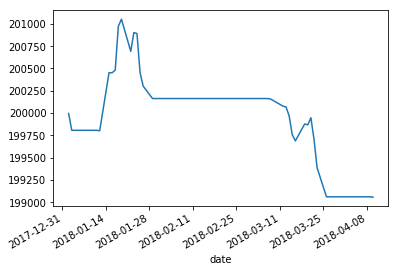

In [38]:
Risk.assets.plot()

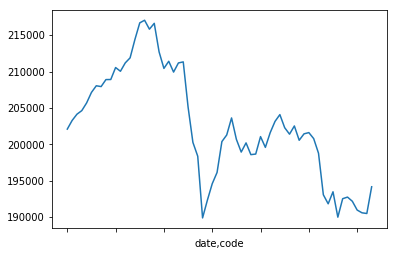

In [39]:
Risk.benchmark_assets.plot()

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

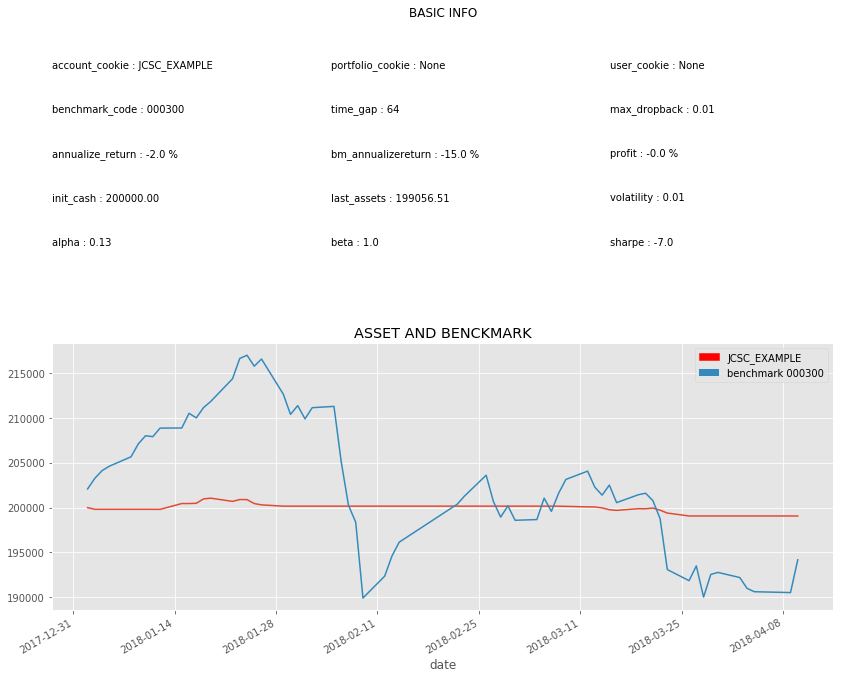

In [40]:
Risk.plot_assets_curve()

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

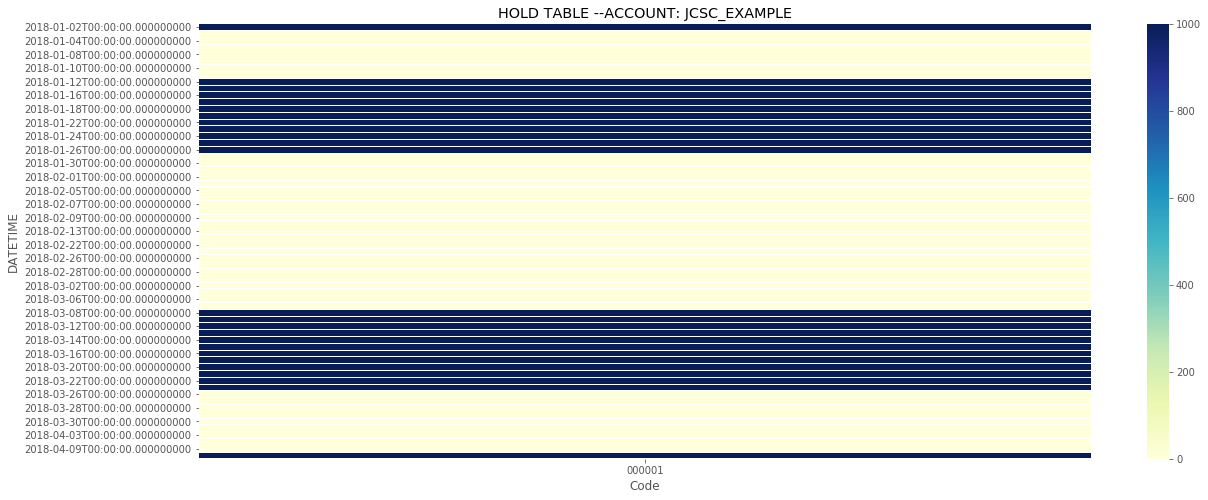

In [41]:
Risk.plot_dailyhold()

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

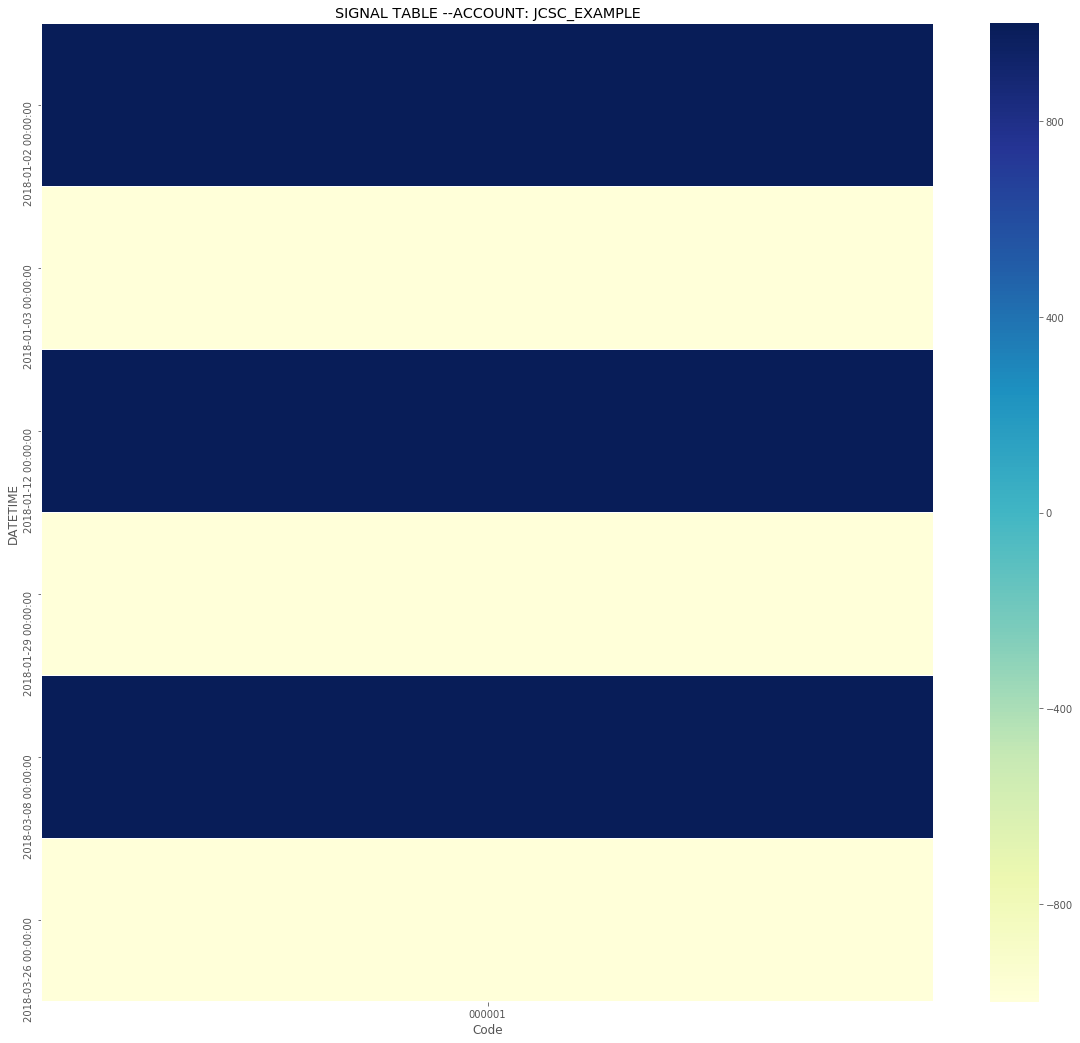

In [42]:
Risk.plot_signal()

In [43]:
Risk.profit_construct

{'total_buyandsell': -870.0,
 'total_tax': -38.49,
 'total_commission': -35.0,
 'total_profit': -943.49}

In [44]:
Performance=QA.QA_Performance(Account)

In [45]:
Performance.pnl_fifo

,sell_date,buy_date,amount,sell_price,buy_price,pnl_ratio,pnl_money
code,,,,,,,
000001,2018-01-03,2018-01-02,1000,13.53,13.70,-0.012409,-170.0
000001,2018-01-29,2018-01-12,1000,13.93,13.55,0.028044,380.0
000001,2018-03-26,2018-03-08,1000,11.03,12.11,-0.089182,-1080.0


<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

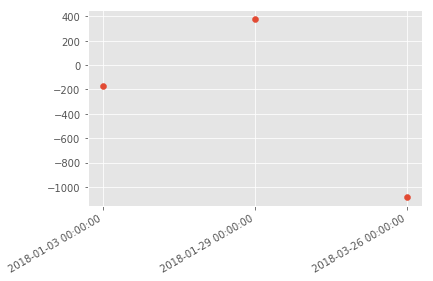

In [46]:
Performance.plot_pnlmoney(Performance.pnl_fifo)

## STEP6: 存储结果

In [47]:
Account.save()
Risk.save()

## STEP7: 查看存储的结果

In [48]:
account_info=QA.QA_fetch_account({'account_cookie':'JCSC_EXAMPLE'})

In [49]:
account=QA.QA_Account().from_message(account_info[0])

In [50]:
account

< QA_Account JCSC_EXAMPLE>